In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [12]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [13]:
%watermark --iversions

altair    4.0.1
xarray    0.14.1
numpy     1.18.1
pandas    1.1.0



In [14]:
from utils.load import load_sensitivity_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors, rms_errors, spearman_errors)

## Set paths 

In [15]:
((zwf_df, pgi_df, eno_df), debug_info) = load_sensitivity_data()

In [16]:
zwf_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.020954,ACALD,ACALD,Khodayari,dzwf,-0.472740
1,-0.004096,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,dzwf,-0.092400
2,-0.009307,ACKr,ACKr,Khodayari,dzwf,-0.209985
3,4.326233,ACONTa,ACONTa,Khodayari,dzwf,97.604637
4,4.441212,ACONTb,ACONTb,Khodayari,dzwf,100.198682


In [17]:
xdf_zwf = process_data(zwf_df, author="Nicolas")
xdf_pgi = process_data(pgi_df, author="Usui")
xdf_eno = process_data(eno_df, author="Usui")

In [18]:
xdf_pgi.BiGG_ID

<xarray.DataArray 'BiGG_ID' (BiGG_ID: 29)>
array(['ACKr', 'AKGDH', 'CS', 'EDA', 'EDD', 'ENO', 'FBA', 'FUM', 'G6PDH2r',
       'GAPD', 'GLCptspp', 'GND', 'ICDHyr', 'ICL', 'PDH', 'PFK', 'PGI', 'PGK',
       'PGM', 'PPC', 'PPCK', 'PTAr', 'PYK', 'RPE', 'RPI', 'SUCDi', 'TALA',
       'TKT1', 'TPI'], dtype=object)
Coordinates:
  * BiGG_ID  (BiGG_ID) object 'ACKr' 'AKGDH' 'CS' 'EDA' ... 'TALA' 'TKT1' 'TPI'

# 2. Calculate error metrics

In [19]:
x_rel_error_zwf = relative_errors(xdf_zwf, author="Nicolas")
x_rel_error_pgi = relative_errors(xdf_pgi, author="Usui")
x_rel_error_eno = relative_errors(xdf_eno, author="Usui")

In [20]:
x_norm_error_zwf = summary_errors(xdf_zwf, author="Nicolas")
x_norm_error_pgi = summary_errors(xdf_pgi, author="Usui")
x_norm_error_eno = summary_errors(xdf_eno, author="Usui")

In [21]:
x_rmse_zwf = rms_errors(xdf_zwf, author="Nicolas")
x_rmse_pgi = rms_errors(xdf_pgi, author="Usui")
x_rmse_eno = rms_errors(xdf_eno, author="Usui")

/Users/denshe/anaconda3/envs/dataml/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
x_spearman_zwf = spearman_errors(xdf_zwf, author="Nicolas")
x_spearman_pgi = spearman_errors(xdf_pgi, author="Usui")
x_spearman_eno = spearman_errors(xdf_eno, author="Usui")

In [23]:
x_norm_error_zwf.sel(author="Chassagnole")

<xarray.Dataset>
Dimensions:             (sample_id: 3)
Coordinates:
  * sample_id           (sample_id) object 'WT' 'dzwf' 'zwf(15)'
    author              <U11 'Chassagnole'
Data variables:
    normalized_error    (sample_id) float64 0.4731 0.416 0.642
    unnormalized_error  (sample_id) float64 151.8 150.1 203.5

In [24]:
summary_errors = xr.concat([x_norm_error_zwf, x_norm_error_pgi, x_norm_error_eno], dim = "sample_id")

In [25]:
rms_errors = xr.concat([x_rmse_zwf, x_rmse_pgi, x_rmse_eno], dim = "sample_id")

In [26]:
spearman_errors = xr.concat([x_spearman_zwf, x_spearman_pgi, x_spearman_eno], dim = "sample_id")

In [27]:
sample_map = {
    "WT" : "WT",
    "dzwf" : "dzwf",
    "zwf(15)" : "15X zwf",
    "dpgi" : "dpgi",
    "pgi(0)" : "0.2X pgi",
    "pgi(20)" : "1.2X pgi",
    "pgi(50)" : "2.4X pgi",
    "pgi(100)" : "4.1X pgi",
    "eno(0)" : "0.2X eno",
    "eno(50)" : "1.8X eno",
    "eno(200)" : "3.0X eno",
    "eno(500)" : "3.1X eno",
}

summary_errors["sample_id"] = summary_errors.sample_id.to_series().apply(lambda x: sample_map[x])
rms_errors["sample_id"] = rms_errors.sample_id.to_series().apply(lambda x: sample_map[x])
spearman_errors["sample_id"] = spearman_errors.sample_id.to_series().apply(lambda x: sample_map[x])

# 4. Visualize

### Summary normalized error for the models

In [28]:
from utils.vis import heatmap, jitter_summary_chart, boxplot

In [29]:
boxplot(norm_error=summary_errors,
                     author=["Nicolas","Usui"],
                     title="Enzyme abundance",
                     sort_list=["Chassagnole", "Khodayari", "Millard", "Kurata"],
                     opacity = False,
              color_scheme = "dark2")

alt.FacetChart(...)

In [30]:
boxplot(norm_error=rms_errors,
                     author=["Nicolas","Usui"],
                     title="Enzyme abundance",
                     sort_list=["Chassagnole", "Khodayari", "Millard", "Kurata"],
                     opacity = False,
              color_scheme = "dark2",
              field="RMSE",
            field_name = "RMSE")

alt.FacetChart(...)

In [25]:
boxplot(norm_error=spearman_errors,
                     author=["Nicolas","Usui"],
                     title="Enzyme abundance",
                     sort_list=["Chassagnole", "Khodayari", "Millard", "Kurata"],
                     opacity = False,
              color_scheme = "dark2",
              field="SpearmanR",
            field_name = "SpearmanR")

alt.FacetChart(...)

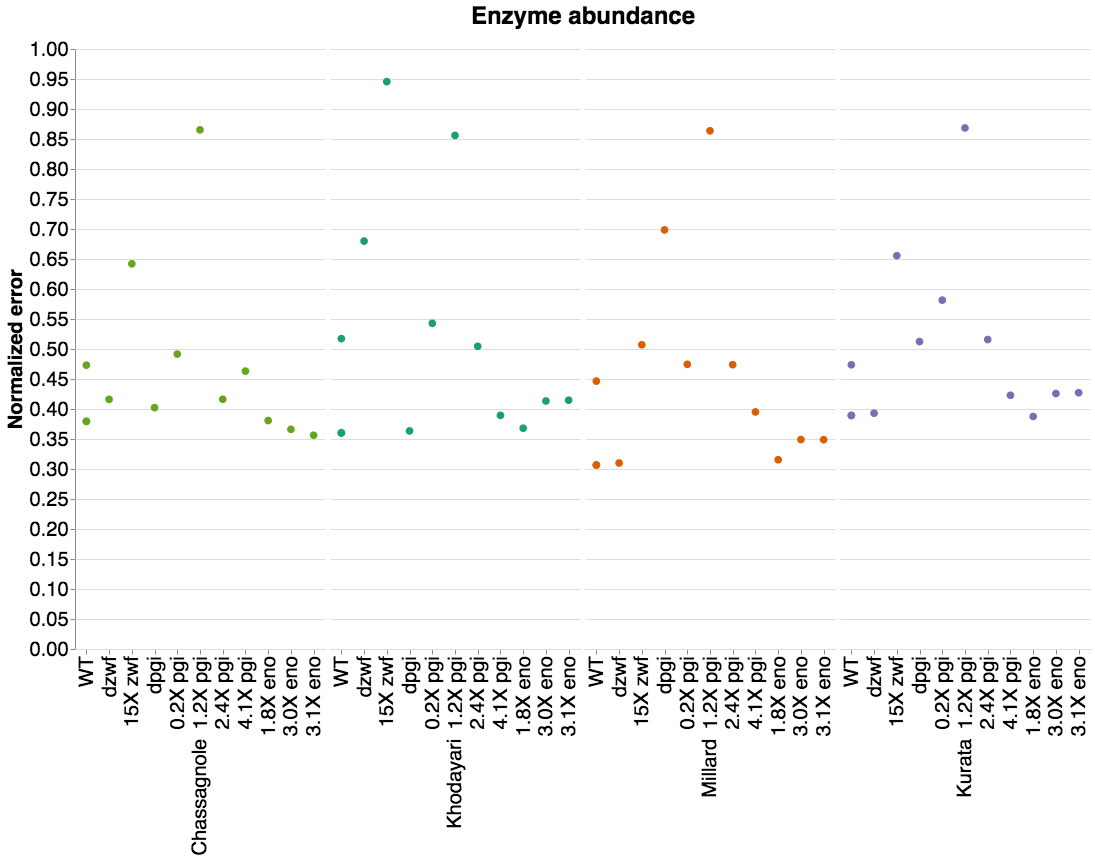

In [16]:
domain = [
        "Khodayari",
        "Millard",
        "Kurata",
        "iML1515",
        "Chassagnole",
        "Exp_iML1515",
        "Exp_ECC2",
        "Long",
    ]
range_ = [
        "#1b9e77",
        "#d95f02",
        "#7570b3",
        "#e7298a",
        "#66a61e",
        "#e6ab02",
        "#a6761d",
        "#666666",
    ]

author=["Nicolas","Usui"]
sort_list=["Chassagnole", "Khodayari", "Millard", "Kurata"],

source = summary_errors.to_dataframe().reset_index()
if type(author) == list:
    source = source.query(f"author not in @author")
elif type(author) == str:
    source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])

opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

    
stripplot = (
    alt.Chart(source, width=250, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "sample_id:O",
            title=None,
            #axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
            sort = ["WT", "dzwf", "15X zwf", "dpgi", "0.2X pgi", "1.2X pgi", "2.4X pgi", "4.1X pgi", "1.8X eno","3.0X eno","3.1X eno"]
        ),
        y=alt.Y("normalized_error:Q", title="Normalized error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Enzyme abundance",
            ),
            sort=["Chassagnole", "Khodayari", "Millard", "Kurata"],
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "normalized_error"],
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)


In [26]:
heatmap(xdf=x_rel_error_zwf, author="Khodayari")

alt.Chart(...)

In [27]:
heatmap(xdf=x_rel_error_zwf, author="Kurata")

alt.Chart(...)

In [28]:
heatmap(xdf=x_rel_error_zwf, author="Millard")

alt.Chart(...)

In [29]:
heatmap(xdf=x_rel_error_zwf, sample_id = "zwf(15)")

alt.Chart(...)

In [30]:
heatmap(xdf=x_rel_error_pgi, sample_id = "pgi(20)")

alt.Chart(...)

# Export the data

In [33]:
sensitivity_data = pd.concat([selected_data_zwf, selected_data_pgi, selected_data_eno], sort=False)

In [37]:
data_path = Path('../data')
path = data_path / "Processed"
path.mkdir(parents=True, exist_ok=True)
sensitivity_data.to_csv(path / "sensitivity.csv")